In [1]:
%cd ~/repo/protein-transfer

/home/t-fli/repo/protein-transfer


In [2]:
%load_ext blackcellmagic

In [17]:
import torch

# Load ESM-1b model
model, alphabet = torch.hub.load(
            "facebookresearch/esm:main", model="esm1_t6_43M_UR50S"
        )
batch_converter = alphabet.get_batch_converter()
# model.eval()  # disables dropout for deterministic results

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
"""
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein2 with mask","KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein3",  "K A <mask> I S Q"),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[6], return_contacts=True)
token_representations = results["representations"][6]

# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, (_, seq) in enumerate(data):
    sequence_representations.append(token_representations[i, 1 : len(seq) + 1].mean(0))
    """

Using cache found in /home/t-fli/.cache/torch/hub/facebookresearch_esm_main


'\ndata = [\n    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),\n    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),\n    ("protein2 with mask","KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),\n    ("protein3",  "K A <mask> I S Q"),\n]\nbatch_labels, batch_strs, batch_tokens = batch_converter(data)\n\n# Extract per-residue representations (on CPU)\nwith torch.no_grad():\n    results = model(batch_tokens, repr_layers=[6], return_contacts=True)\ntoken_representations = results["representations"][6]\n\n# Generate per-sequence representations via averaging\n# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.\nsequence_representations = []\nfor i, (_, seq) in enumerate(data):\n    sequence_representations.append(token_representations[i, 1 : len(seq) + 1].mean(0))\n    '

In [4]:
# https://github.com/ChrisMats/feature-reuse/blob/main/ablations/layer_importance/trainer.py
import torch.nn as nn
import math

def rand_weights_init(m, sampling_fn=None):  
    if sampling_fn is None:
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5)) 
            if m.bias is not None:
                fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(m.weight)
                bound = 1 / math.sqrt(fan_in)
                torch.nn.init.uniform_(m.bias, -bound, bound)        
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5)) 
            if m.bias is not None:
                fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(m.weight)
                bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
                torch.nn.init.uniform_(m.bias, -bound, bound)        
    else:
        tmp_state = m.state_dict()
        for name_, module_ in m.named_modules():
            if isinstance(module_, (nn.Linear,nn.Conv2d)):
                weight_name = f"{name_}{'.' if name_ else ''}weight"
                bias_name = f"{name_}{'.' if name_ else ''}bias"
                tmp_state[weight_name] = sampling_fn(tmp_state[weight_name])
                if bias_name in tmp_state:
                    tmp_state[bias_name] = sampling_fn(tmp_state[bias_name])        
        m.load_state_dict(tmp_state)

In [62]:
import copy
loaded_model = copy.deepcopy(model)

In [18]:
for name, layer in model.named_modules():
    if name in ["layers.0", ]:
        print(f"changing {name}")
        pre_rand_weight = layer.state_dict()['final_layer_norm.weight']
        pre_rand_bias = layer.state_dict()['final_layer_norm.bias']
        layer.apply(lambda m: rand_weights_init(m=m, sampling_fn = nn.init.uniform_))
        post_rand_weight = layer.state_dict()['final_layer_norm.weight']
        post_rand_bias = layer.state_dict()['final_layer_norm.bias']

changing layers.0


In [6]:
import matplotlib.pyplot as plt

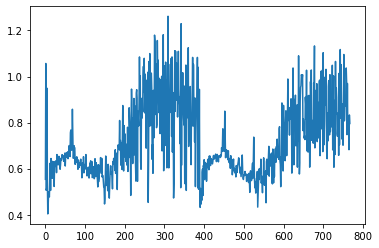

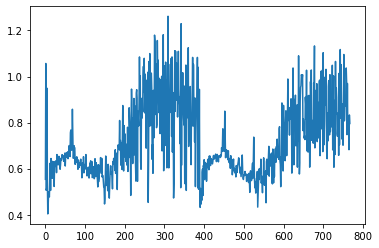

In [19]:
plt.plot(pre_rand_weight)
plt.figure()
plt.plot(post_rand_weight)

(array([ 18., 105., 265., 104.,  77.,  85.,  56.,  43.,  11.,   4.]),
 array([0.4033203 , 0.48916015, 0.575     , 0.66083986, 0.74667966,
        0.83251953, 0.9183594 , 1.0041993 , 1.090039  , 1.1758789 ,
        1.2617188 ], dtype=float32),
 <BarContainer object of 10 artists>)

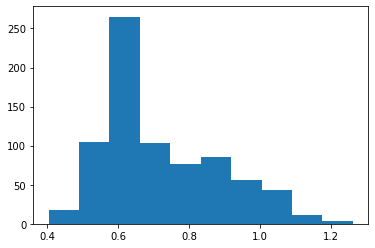

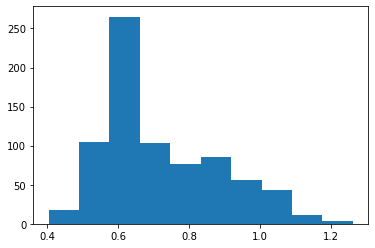

In [20]:
plt.hist(pre_rand_weight)
plt.figure()
plt.hist(post_rand_weight)

In [ ]:
for l in model.children():
  try:
    init.kaiming_normal_(l.weight)
    l.bias.data.zero_()
  except:
    pass

def stats(x): return x.mean(),x.std()


for i,e in enumerate(model.children()):
  print(i,e)
  print('-----Layer Mean and std',stats(e.weight))

In [ ]:
"""
layer.weight.data.fill_(random_weight)
layer.bias.data.fill_(random_bias)
"""

In [28]:
model.layers[0]

TransformerLayer(
  (self_attn): MultiheadAttention(
    (k_proj): Linear(in_features=768, out_features=768, bias=True)
    (v_proj): Linear(in_features=768, out_features=768, bias=True)
    (q_proj): Linear(in_features=768, out_features=768, bias=True)
    (out_proj): Linear(in_features=768, out_features=768, bias=True)
  )
  (self_attn_layer_norm): ESM1LayerNorm()
  (fc1): Linear(in_features=768, out_features=3072, bias=True)
  (fc2): Linear(in_features=3072, out_features=768, bias=True)
  (final_layer_norm): ESM1LayerNorm()
)

In [27]:
[p.shape for p in model.layers[0].parameters()]

[torch.Size([1, 1, 768]),
 torch.Size([1, 1, 768]),
 torch.Size([768, 768]),
 torch.Size([768]),
 torch.Size([768, 768]),
 torch.Size([768]),
 torch.Size([768, 768]),
 torch.Size([768]),
 torch.Size([768, 768]),
 torch.Size([768]),
 torch.Size([768]),
 torch.Size([768]),
 torch.Size([3072, 768]),
 torch.Size([3072]),
 torch.Size([768, 3072]),
 torch.Size([768]),
 torch.Size([768]),
 torch.Size([768])]

In [ ]:
# https://discuss.pytorch.org/t/how-to-change-the-weights-of-a-pytorch-model/41279/3

"""
model.eval()  
    with torch.no_grad():
        for data, target  in test_loader:
            data, target = data.to(device), target.to(device)
            model.fc.weight = model.fc.weight * attention_matrix
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
"""

# model.fc.weight = torch.nn.parameter.Parameter( model.fc.weight * attention_matrix )